# Comparision between linear and non-linear classifier in quantification

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import baycomp as bc
import glob
import os
from tqdm import tqdm

## Load results

In [53]:
results = pd.read_csv("results_distance_methods_20x50_agg.csv")

## Summaries

In [54]:
mae_results = results.groupby(['method'])[['mae']].agg(['mean', 'median'])
mae_results

mae          
            mean    median
method                    
AC      0.315647  0.009813
CvMy    0.277736  0.039090
EDX     0.043442  0.009312
EDy     0.182556  0.010770
HDX     0.039212  0.012007
HDy     0.080429  0.007593

In [55]:
results.groupby(['dataset', 'method'])[['mae']].agg(["mean", "median"]).unstack().round(3)

mae                                                   \
                     mean                                    median          
method                 AC   CvMy    EDX    EDy    HDX    HDy     AC   CvMy   
dataset                                                                      
acute.a             0.089  0.288  0.015  0.070  0.017  0.042  0.007  0.177   
acute.b             0.038  0.272  0.006  0.043  0.007  0.055  0.007  0.158   
balance.1           0.037  0.097  0.009  0.041  0.005  0.007  0.011  0.058   
balance.3           0.031  0.046  0.006  0.026  0.008  0.007  0.013  0.029   
breast-cancer       0.002  0.050  0.003  0.002  0.002  0.001  0.002  0.008   
cmc.1               0.137  0.143  0.065  0.101  0.033  0.034  0.044  0.027   
cmc.2               0.439  0.357  0.044  0.321  0.031  0.102  0.147  0.196   
cmc.3               0.716  0.670  0.078  0.450  0.049  0.085  0.189  0.488   
coil                0.236  0.265  0.046  0.277  0.101  0.264  0.044  0.087   
ctg.1               0.007  0.032  0.004  0.004  0.007  0.002  0.002  0.009   
ctg.2               0.026  0.029  0.015  0.010  0.008  0.003  0.003  0.003   
ctg.3               0.027  0.028  0.010  0.009  0.026  0.004  0.006  0.013   
default_credit      0.002  0.002  0.002  0.002  0.002  0.003  0.001  0.002   
diabetes            0.203  0.121  0.019  0.103  0.034  0.027  0.090  0.069   
german              0.282  0.264  0.028  0.212  0.047  0.071  0.112  0.022   
haberman            5.594  3.154  0.483  2.646  0.381  1.161  2.770  0.743   
ionosphere          0.114  0.239  0.023  0.108  0.025  0.010  0.019  0.153   
iris.1              0.000  0.168  0.003  0.003  0.002  0.005  0.000  0.046   
iris.2              0.320  0.321  0.087  0.113  0.013  0.059  0.014  0.179   
iris.3              0.032  0.178  0.066  0.101  0.017  0.084  0.007  0.023   
lettersH            0.002  0.017  0.008  0.014  0.004  0.001  0.001  0.003   
mammographic        0.044  0.028  0.019  0.016  0.011  0.013  0.014  0.007   
normtrans           0.589  0.520  0.148  0.370  0.181  0.553  0.124  0.175   
normwine.1          0.014  0.296  0.015  0.045  0.010  0.016  0.008  0.209   
normwine.2          0.081  0.130  0.015  0.046  0.022  0.018  0.012  0.050   
normwine.3          0.030  0.168  0.005  0.018  0.014  0.014  0.007  0.044   
pageblocks.5        0.091  0.042  0.018  0.033  0.060  0.016  0.005  0.006   
phoneme             0.002  0.015  0.005  0.005  0.002  0.001  0.001  0.003   
semeion.8           0.100  0.033  0.050  0.014  0.025  0.009  0.015  0.009   
sonar               0.526  0.248  0.042  0.184  0.066  0.066  0.272  0.067   
spambase            0.000  0.002  0.001  0.001  0.002  0.000  0.000  0.002   
spectf              1.782  1.015  0.140  0.766  0.046  0.166  0.688  0.863   
tictactoe           0.036  0.209  0.043  0.133  0.031  0.011  0.008  0.159   
transfusion         0.885  0.949  0.187  0.827  0.236  0.297  0.346  0.349   
wdbc                0.002  0.023  0.006  0.003  0.006  0.002  0.002  0.008   
wine-quality-red    0.077  0.056  0.007  0.037  0.010  0.006  0.008  0.016   
wine-quality-white  0.010  0.015  0.004  0.010  0.005  0.003  0.003  0.005   
wine.1              0.037  0.204  0.008  0.025  0.007  0.018  0.013  0.112   
wine.2              0.054  0.282  0.013  0.117  0.024  0.011  0.006  0.096   
wine.3              0.012  0.212  0.008  0.020  0.013  0.006  0.004  0.024   
yeast               0.237  0.197  0.030  0.156  0.020  0.044  0.039  0.052   

                                                
                                                
method                EDX    EDy    HDX    HDy  
dataset                                         
acute.a             0.010  0.012  0.013  0.017  
acute.b             0.005  0.014  0.005  0.013  
balance.1           0.004  0.009  0.005  0.004  
balance.3           0.005  0.016  0.005  0.005  
breast-cancer       0.001  0.002  0.002  0.001  
cmc.1               0.034  0.025  0.023  0.018  
cmc.2               0

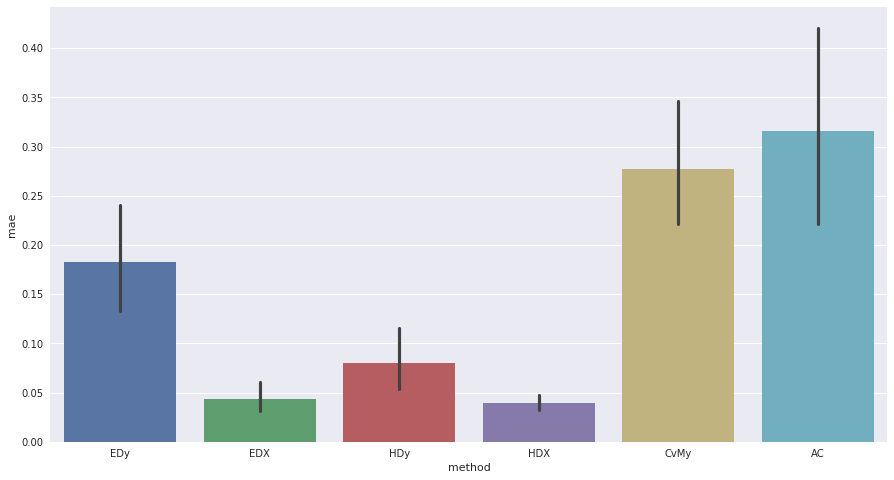

In [56]:
_, ax = plt.subplots(1,1,figsize=(15, 8))
sns.barplot(x="method", y="mae", data=results, 
            #order=["AC_linear", "AC_nonlinear", "AC_nonlinear_geometric", "EDX", "EDy_linear", "EDy_nonlinear", 
            #       "EDy_nonlinear_geometric", "HDX", "HDy_linear", "HDy_nonlinear", "HDy_nonlinear_geometric"]
           )

In [64]:
def get_data_one_ds(method, dataset, aggregate=False):
    results = pd.read_csv("results_distance_methods_20x50_agg.csv")

    results = results[np.logical_and(results.method == method, results.dataset == dataset)]
    maes = results["mae"].values

    if aggregate:
        maes = maes.mean(axis=1)

    inv_maes = 1 - maes
    return inv_maes

datasets_dir = "datasets"
dataset_files = [file for file in glob.glob(os.path.join(datasets_dir, "*.csv")) if file not in ["datasets/balance.2.csv", "datasets/lettersG.csv", "datasets/k9.csv"]]
dataset_names = [os.path.split(name)[-1][:-4] for name in dataset_files]

In [65]:
methods = ["EDX", "EDy", "HDX", "HDy", "AC", "CvMy"]

methods_combs = combinations(methods, 2)
two_on_single_df = pd.DataFrame(columns=["Cuantificador1", "Cuantificador2", "Dataset", "p(m1)", "p(rope)", "p(m2)"])

for m1, m2 in tqdm(methods_combs):
    for dname in dataset_names:
        data1 = get_data_one_ds(m1, dname)
        data2 = get_data_one_ds(m2, dname)
        test = bc.two_on_single(data1, data2, rope=0.01, runs=20)
        two_on_single_df = two_on_single_df.append(pd.DataFrame([[m1, m2, dname] + list(test)], columns=["Cuantificador1", "Cuantificador2", "Dataset", "p(m1)", "p(rope)", "p(m2)"]))
two_on_single_df["Par"] = two_on_single_df.Cuantificador1 + "-" + two_on_single_df.Cuantificador2

0it [00:00, ?it/s]


ZeroDivisionError: float division by zero

In [60]:
two_on_single_df[["n(m1)", "n(rope)", "n(m2)"]] = (two_on_single_df[["p(m1)", "p(rope)", "p(m2)"]] > 0.95)
final_df = two_on_single_df.groupby("Par").sum()[["n(m1)", "n(rope)", "n(m2)"]]
final_df["n(no_decision)"] = 41 - final_df["n(m1)"] - final_df["n(m2)"] - final_df["n(rope)"]
final_df.sum() / 615

n(m1)             0.102439
n(rope)           0.178862
n(m2)             0.055285
n(no_decision)    0.663415
dtype: float64

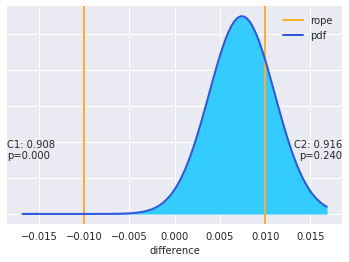

In [61]:
data1 = get_data_one_ds("EDX", "coil")
data2 = get_data_one_ds("EDy", "coil")
test = bc.two_on_single(data1, data2, rope=0.01, plot=True)

In [62]:
final_df

,n(m1),n(rope),n(m2),n(no_decision)
Par,,,,
AC-CvMy,4.0,3.0,0.0,34.0
EDX-AC,4.0,5.0,4.0,28.0
EDX-CvMy,9.0,5.0,1.0,26.0
EDX-EDy,3.0,9.0,2.0,27.0
EDX-HDX,9.0,9.0,2.0,21.0
EDX-HDy,3.0,4.0,2.0,32.0
EDy-AC,0.0,10.0,1.0,30.0
EDy-CvMy,7.0,21.0,0.0,13.0
EDy-HDX,7.0,7.0,2.0,25.0


In [63]:
two_on_single_df[np.logical_or(np.logical_or(two_on_single_df["p(m1)"] == 1.0, two_on_single_df["p(m2)"] == 1.0), two_on_single_df["p(rope)"] == 1.0)].shape

(4, 10)

(615, 10)

0.18699186991869918